## Modules

In [1]:
# import basic modules
import pandas as pd
import warnings
import numpy as np
import os
import glob

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## Import Data

In [5]:
# read in all the csv-files
path = os.getcwd() + "/Model Data/Univariate"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

In [6]:
# set the date as index
for i in range(len(file_list)):
    file_list[i]["DATE"] = pd.to_datetime(file_list[i]["DATE"])
    file_list[i].set_index("DATE", inplace = True)

In [7]:
training, testing = [f for f in file_list]

## Model Evaluation (in-sample)

### (Automated Version)

In [8]:
# in-sample forecast evaluation for arima models:
# 1. fit model parameters on the training sample and compute the aicc
# 2. produce one-step-ahead forecasts from the end of that sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare forecasts against training sample to compute rmse
def evaluate_model(training, order):
    # fit model on training sample
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    # save original data and fitted values
    model_data = training.copy()
    model_data["prediction"] = model_fit.fittedvalues
    # compute the rmse for the given combination of (p,d,q)
    rmse = np.sqrt(mean_squared_error(training, model_fit.fittedvalues))
    # return the rmse, fitted values, aicc score and residuals
    return model_fit.aicc, rmse, model_data, model_fit.resid

### (Manual Version)

In [9]:
"""
# split the training data into training and validation sets
def validation_split(data, ratio):
    training_size = int(len(data) * ratio)
    training, validation = data[0:training_size], data[training_size:]
    return training, validation
    
# 70% training data and 30% validation data
training, validation = validation_split(training, 0.7)

def evaluate_model(training, validation, order):
    history = [x for x in training.values]
    predictions = list()
    # iterate over each value in the validation set
    for t in range(len(validation.values)):
        # fit model on training sample
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        # compute one-step-ahead forecast
        y_hat = model_fit.forecast()[0]
        # append prediction to list
        predictions.append(y_hat)
        # expand the training sample to include next observation and repeat
        history.append(validation.values[t])
    # compute rmse
    rmse = np.sqrt(mean_squared_error(validation, predictions))
    # save original data and fitted values
    model_data = validation.copy()
    model_data["prediction"] = predictions
    # return the rmse and the fitted values for a given combination of (p,d,q)
    return model_fit.aicc, rmse, model_data, model_fit.resid
""";

$$ 
\text{ARIMA(p,d,q) } : \;\; \Delta^{d}X_{t} = c + \sum^{p}_{i=1}\alpha_{i}\Delta^{d}X_{t-i} + \sum^{q}_{j=1}\beta_{j}X_{t-j} + \epsilon_{t}
$$

### Grid-Search

In [10]:
# grid-search for finding the best combination of arima parameters (p,d,q)
def grid_search(training, p_grid, d, q_grid):
    best_score, best_cfg = float("inf"), None
    aicc_values = list()
    for p in p_grid:
        for q in q_grid:
            order = (p,d,q)
            try:
                aicc, rmse, model_data, residuals = evaluate_model(training, order)
                if aicc < best_score:
                    best_score, best_rmse, best_cfg, best_model_data, best_resid = aicc, rmse, order, model_data, residuals
                print("> ARIMA%s; AICc = %.2f" % (order, aicc))
                aicc_values.append(aicc)
            except:
                continue
    # print best model and return best configuration and best scores 
    print("> best model: ARIMA%s with AICc of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aicc_values, best_rmse, best_resid

In [11]:
# select range of (p,d,q) parameters
p, d, q = range(0,6), 0, range(0,6)

In [12]:
# run the grid-search
best_cfg, model_data, aicc_values, rmse, residuals = grid_search(training, p, d, q)

> ARIMA(0, 0, 0); AICc = 742.10
> ARIMA(0, 0, 1); AICc = 712.91
> ARIMA(0, 0, 2); AICc = 698.72
> ARIMA(0, 0, 3); AICc = 697.37
> ARIMA(0, 0, 4); AICc = 698.85
> ARIMA(0, 0, 5); AICc = 697.73
> ARIMA(1, 0, 0); AICc = 699.86
> ARIMA(1, 0, 1); AICc = 698.75
> ARIMA(1, 0, 2); AICc = 697.54
> ARIMA(1, 0, 3); AICc = 699.28
> ARIMA(1, 0, 4); AICc = 698.63
> ARIMA(1, 0, 5); AICc = 698.47
> ARIMA(2, 0, 0); AICc = 697.16
> ARIMA(2, 0, 1); AICc = 697.61
> ARIMA(2, 0, 2); AICc = 698.98
> ARIMA(2, 0, 3); AICc = 700.14
> ARIMA(2, 0, 4); AICc = 694.90
> ARIMA(2, 0, 5); AICc = 697.04
> ARIMA(3, 0, 0); AICc = 697.64
> ARIMA(3, 0, 1); AICc = 699.14
> ARIMA(3, 0, 2); AICc = 701.02
> ARIMA(3, 0, 3); AICc = 701.11
> ARIMA(3, 0, 4); AICc = 697.03
> ARIMA(3, 0, 5); AICc = 697.70
> ARIMA(4, 0, 0); AICc = 699.34
> ARIMA(4, 0, 1); AICc = 701.19
> ARIMA(4, 0, 2); AICc = 701.76
> ARIMA(4, 0, 3); AICc = 700.81
> ARIMA(4, 0, 4); AICc = 702.82
> ARIMA(4, 0, 5); AICc = 699.38
> ARIMA(5, 0, 0); AICc = 700.12
> ARIMA(

### Model Visualization

In [13]:
# function for visualization of model training and the corresponding aicc
def plot_model(model_data, aicc, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values from model
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.3f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aicc values
    ax2.plot(aicc, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AICc Value")
    ax2.set_title("Corresponding AICc", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    plt.tight_layout()

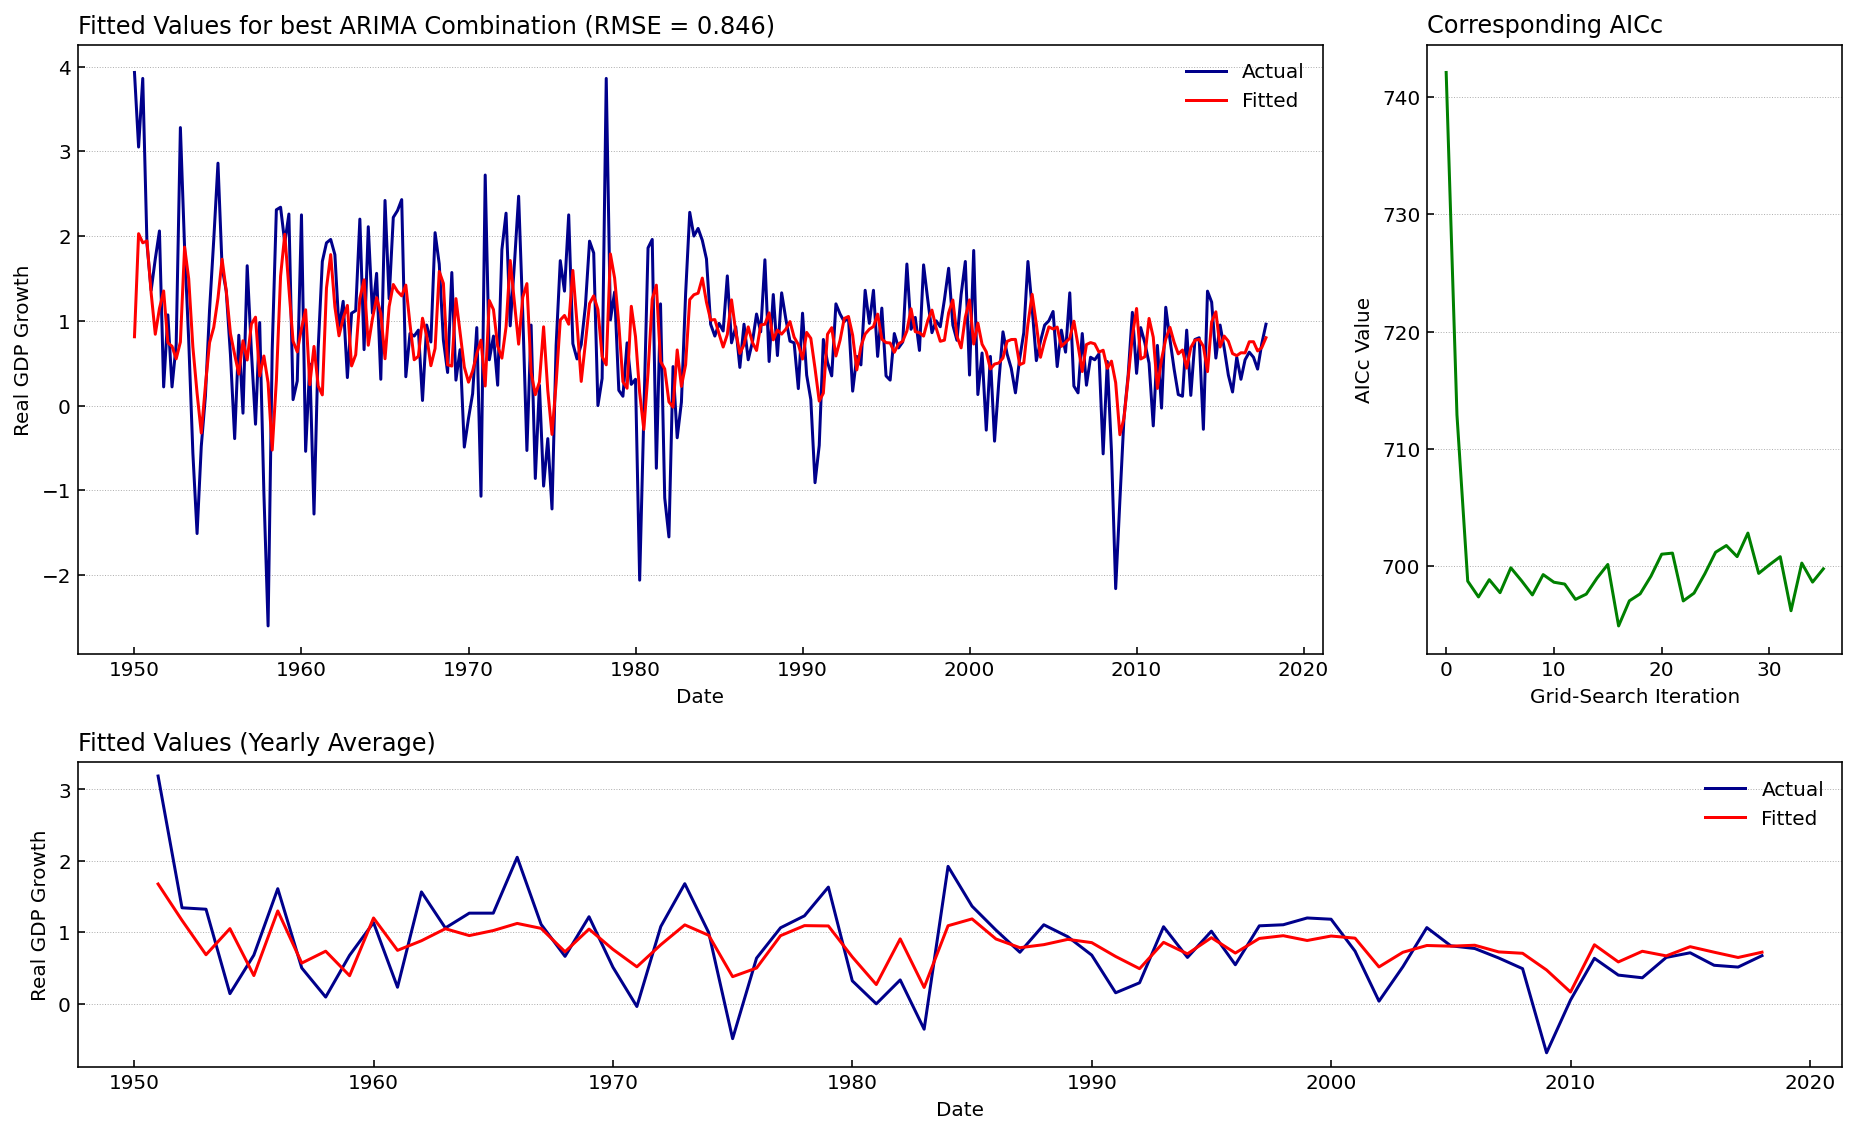

In [14]:
# plot the model training
plot_model(model_data, aicc_values, rmse)

## Residual Diagnostics

In [15]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data):   
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

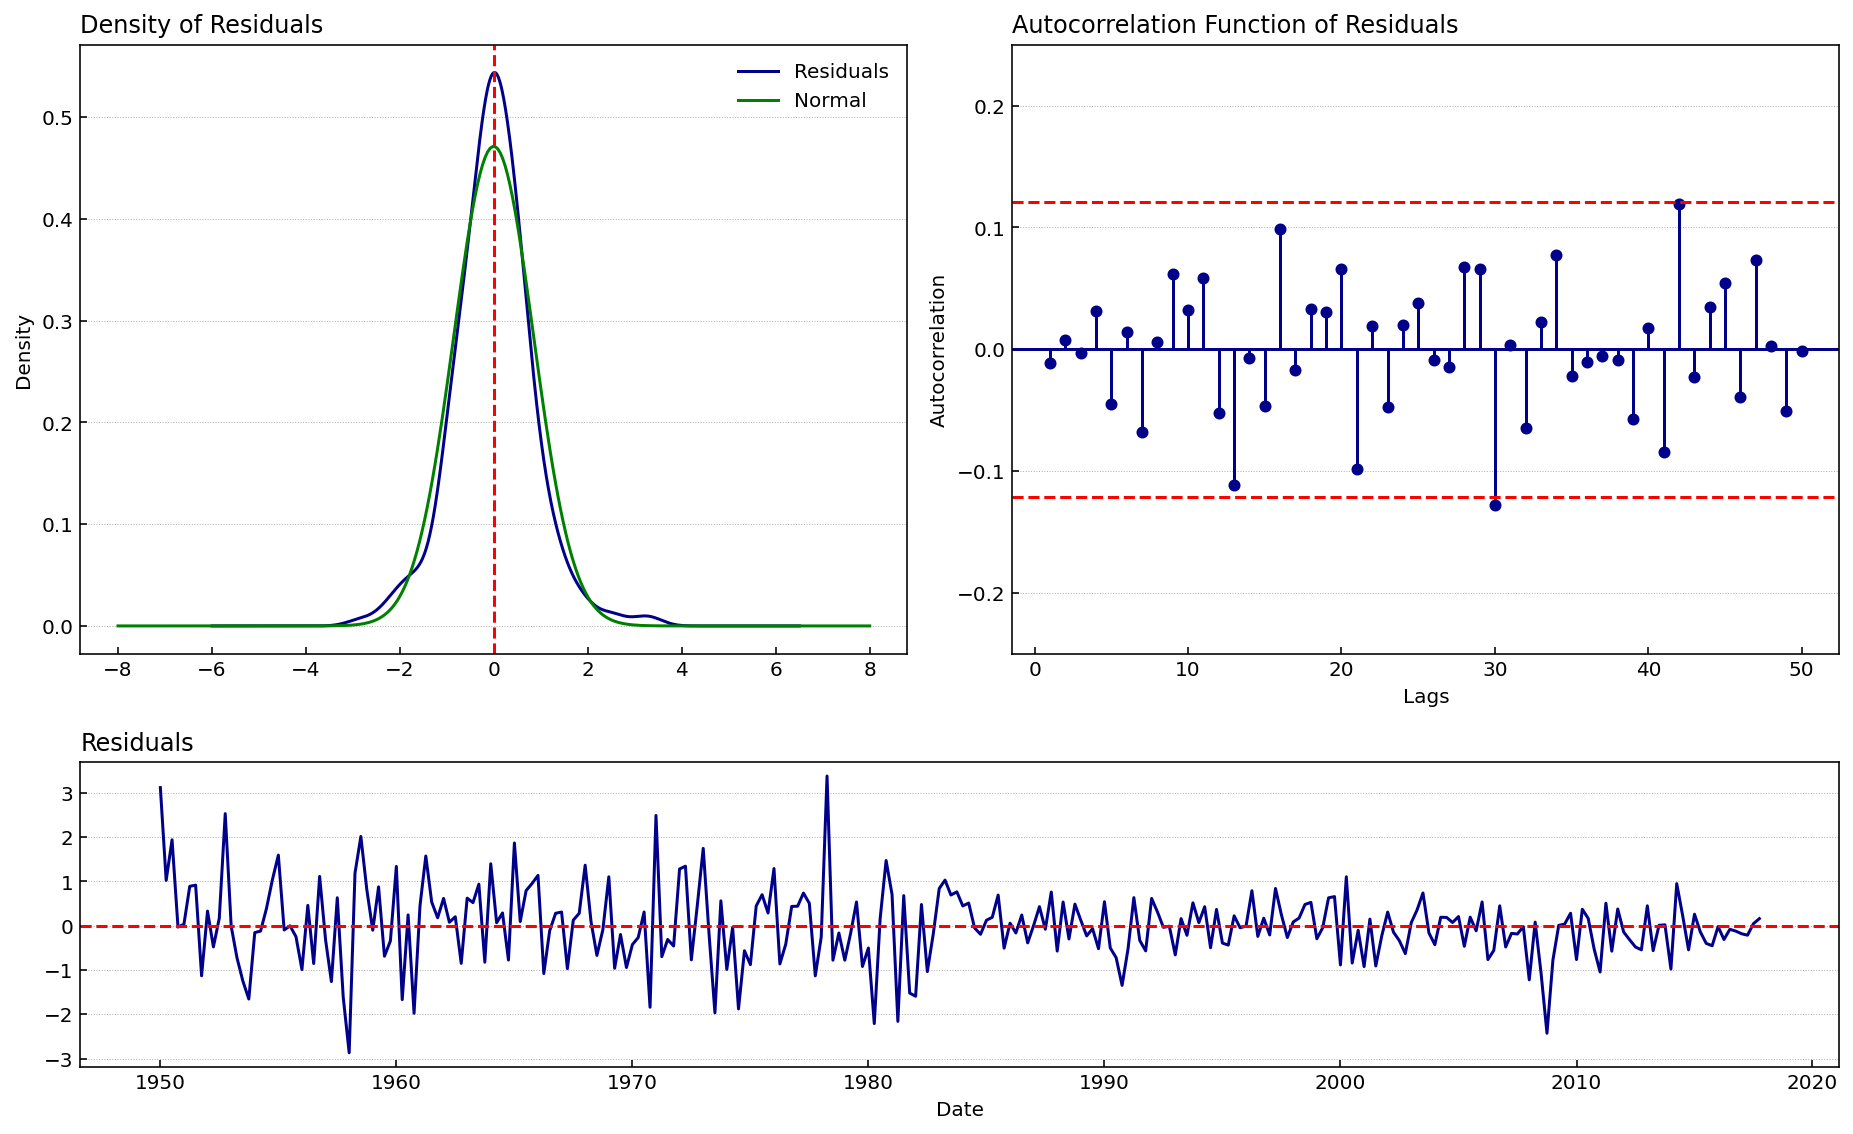

In [16]:
# residuals for chosen parameter combination on full training data
plot_residuals(residuals)

### Goldfeld-Quandt Test for Heteroskedasticity

In [17]:
# source code from statsmodels for heteroskedasticity test (Goldfeld-Quandt) of residuals
def heteroskedasticity_test(resid, subset_length = 1/3):
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    if 0 < subset_length < 1:
        h = int(np.round(nobs * subset_length))
    elif type(subset_length) is int and subset_length >= 1:
        h = subset_length

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    if len(test_statistic) == 1:
        return test_statistic[0], p_value[0]

    return test_statistic, p_value

In [18]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("> goldfeld-quandt test results")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))

$$ \text{Goldfeld-Quandt Test Statistic:} \;\; F = \frac{S^2_{1}}{S^2_{2}} \;\; \text{with} \;\; S^2_{i} = \frac{1}{n_{i}-k}\sum^{n_{i}}_{j=1}\epsilon^2_{ij} $$

In [19]:
gq_test(residuals)

> goldfeld-quandt test results
> test statistic = 0.27
> p-value = 0.00


### Ljung-Box-Q Test for Autocorrelation

In [20]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("> ljung-box test results:")
    print("> average test statistic = %.2f" % (test_statistic))
    print("> average p-value = %.2f" % (p_value))

$$ \text{Ljung-Box-Q Test Statistic :} \;\; Q(m) = n(n+2)\sum^{m}_{h=1}\frac{\hat{\varrho}_{h}^2}{n-h} $$

In [21]:
lbq_test(residuals)

> ljung-box test results:
> average test statistic = 15.15
> average p-value = 0.83


### Jarque-Bera Test for Normality

In [22]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0], jb_test[1], jb_test[2], jb_test[3]
    print("> jarque-bera test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))
    print("> estimated skew = %.2f" % (skew))
    print("> estimated kurtosis = %.2f" % (kurtosis))

$$ \text{Jarque-Bera Test Statistic:} \;\; JB = \frac{N}{6}\left( v^2 + \frac{w^2}{4} \right) $$

In [23]:
jb_test(residuals)

> jarque-bera test results:
> test statistic = 44.98
> p-value = 0.00
> estimated skew = 0.22
> estimated kurtosis = 4.94


## Out-of-Sample Forecast

In [24]:
history = [x for x in training.values]
predictions = list()
# walk-forward validation
for t in range(len(testing.values)):
    model = ARIMA(history, order = best_cfg)
    model_fit = model.fit()
    y_hat = model_fit.forecast()[0]
    predictions.append(y_hat)
    history.append(np.asarray([y_hat]))
    date = str.split(str(testing.index[t]))[0]
    print("> (%s) forecasted = %.2f; actual = %.2f" % (date, y_hat, testing.values[t]))
# evaluate forecasts using rmse
rmse = np.sqrt(mean_squared_error(testing.values, predictions))
# save original data and predicted values
model_data = testing.copy()
model_data["prediction"] = predictions

> (2018-01-01) forecasted = 0.85; actual = 0.93
> (2018-04-01) forecasted = 0.85; actual = 0.67
> (2018-07-01) forecasted = 0.86; actual = 0.53
> (2018-10-01) forecasted = 0.80; actual = 0.33
> (2019-01-01) forecasted = 0.77; actual = 0.73
> (2019-04-01) forecasted = 0.83; actual = 0.37
> (2019-07-01) forecasted = 0.84; actual = 0.64
> (2019-10-01) forecasted = 0.78; actual = 0.59


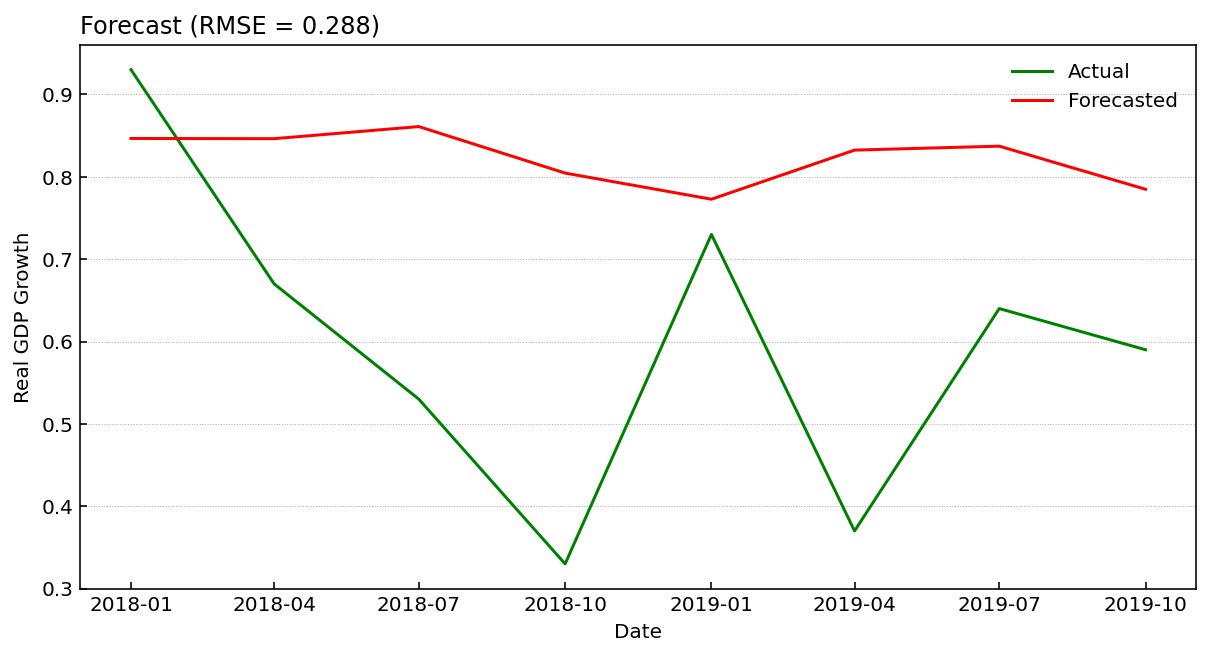

In [25]:
plt.figure(figsize = (10,5))
plt.plot(model_data.iloc[:,0], color = "green", label = "Actual")
plt.plot(model_data.iloc[:,1], color = "red", label = "Forecasted")
plt.xlabel("Date")
plt.ylabel("Real GDP Growth")
plt.title("Forecast (RMSE = %.3f)" % (rmse), loc = "left")
plt.tick_params(direction = "in")
plt.grid(axis = "y", linewidth = 0.5, linestyle = ":")
plt.legend(frameon = False)
plt.show()